# Semantic Search on vector embeddings from scratch
This notebook contains the implemenation of semantic search on vector embeddings from scratch.


### Install dependencies

In [ ]:
%pip install openai cohere tiktoken sentence_transformers


## Load and Process the dataset

The dataset used in this example is [fine-food reviews](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Amazon. The dataset contains a total of 568,454 food reviews Amazon users left up to October 2012. We will use a subset of this dataset, consisting of 1,000 most recent reviews for illustration purposes. The reviews are in English and tend to be positive or negative. Each review has a ProductId, UserId, Score, review title (Summary) and review body (Text).

We will combine the review summary and review text into a single combined text. The model will encode this combined text and it will output a single vector embedding.

For simplicity and easy of understanding we will filter 1000 recent less lengthty reviews for our semantic search analysis

In [2]:
# imports
import pandas as pd
import tiktoken
import numpy as np

In [4]:
# load data
input_datapath = "/content/fine_food_reviews_1k.csv"  # Load the dataset from the dataset path

# Read Data
df = pd.read_csv(input_datapath, index_col=0)

# Extract essential features and drop null values
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()

# Combine summary and text of the food review
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)

# print final dataset
df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title: Arrived in pieces; Content: Not pleased...


In [5]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)
# Encoding to filter out text
embedding_encoding = "cl100k_base"
encoding = tiktoken.get_encoding(embedding_encoding)
max_tokens = 8000
# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)

# Final Dataframe with 1000 reviews
len(df)

1000

## Generate Embeddings for combined text


### Load the text Embedding model
We will be using Sentence Transformers' open source <b>all-MiniLM-L12-v2</b> text embedding model because of its accurate and faster response.
This model encodes the text into vector embedding of 384 dimensions which accurately captures the semantic information in the text.

In [6]:
# Load embedding model
import torch
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
# Check if GPU is available and use it
if torch.cuda.is_available():
    model = model.to(torch.device("cuda"))
print(model.device)

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

cpu


In [7]:
# Generate embeddings for the combined text in the dataframe
df["embedding"] = df.combined.apply(lambda x: model.encode(x))

# save the dataframe(with embeddings) for future use
df.to_csv("/content/fine_food_reviews_with_embeddings_1k.csv")


In [8]:
# Get the dataframe shape
df.shape

(1000, 8)

In [9]:
# remove unwanted features
df = df.drop(['ProductId','UserId','Score',	'Summary',	'Text', 'n_tokens'], axis = 1)

# Final dataframe that stores the text and the corresponding vector embeddings
df.head()

,combined,embedding
0,Title: where does one start...and stop... wit...,"[0.023663158, -0.045518637, 0.022436284, 0.003..."
297,"Title: Good, but not Wolfgang Puck good; Conte...","[-0.027106881, -0.001317336, -0.069813974, -0...."
296,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145..."
295,Title: Best tomato soup; Content: I have a har...,"[-0.0026313225, -0.086089864, 0.068339504, 0.0..."
294,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145..."


## Clustering similar vector embeddings

We will be using <b>KMeans clustering</b> for clustering the vector embeddings into similar groups or partitions.
<br>
<br>
The official <b>FAISS</b> indexing functions also employs similar clustering algorithm to create non interesecting paritions amongst the vector space.
<br>


In [10]:
# Extract vector embeddings in separate variable for clustering
matrix = np.vstack(df.embedding.values)
matrix.shape

(1000, 384)

In [11]:
matrix.shape[0]

1000

### KMeans clustering


In [12]:
# KMeans clustering algorithm from scratch
class KMeans:
    def __init__(self, n_clusters, max_iters=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None

    def fit(self, X):
        np.random.seed(self.random_state)
        # Initialize centroids randomly
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iters):
            # Assign each data point to the nearest centroid
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1)

            # Update centroids based on the mean of data points in each cluster
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # Check for convergence
            if np.allclose(self.centroids, new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2), axis=1)


In [13]:
# considering number of clusters as 5
n_clusters = 5
# Apply Kmeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(matrix)
# Calculate cluster ids
labels = kmeans.predict(matrix)

In [14]:
# Assigning corresponding cluster id to each vector embedding in our dataframe.
df['Cluster'] = labels

In [15]:
# Final Dataframe with text(in Combined column), embedding and the corresponding cluster id
df.head()

,combined,embedding,Cluster
0,Title: where does one start...and stop... wit...,"[0.023663158, -0.045518637, 0.022436284, 0.003...",1
297,"Title: Good, but not Wolfgang Puck good; Conte...","[-0.027106881, -0.001317336, -0.069813974, -0....",0
296,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145...",3
295,Title: Best tomato soup; Content: I have a har...,"[-0.0026313225, -0.086089864, 0.068339504, 0.0...",3
294,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145...",3


### Visualizing the clusters

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

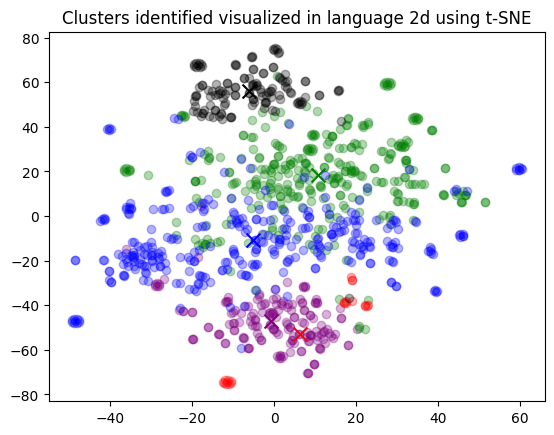

In [16]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","black"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    # The 'X' represents the centroid of the cluster
    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

### Create the index file (Mapping the centroid embedding and cluster id)
We will create a separate dataframe(index file) to store the centroid embeddings and their corresponding cluster id.
<br>
This file will be used later during querying to identify the partition in which your query vector lies and then search for k nearest neighbour vectors of query vector in that partition.

In [17]:
# Identifying unique clusters ids
unique_clusters = np.unique(labels)
unique_clusters = unique_clusters.tolist()
unique_clusters

[0, 1, 2, 3, 4]

In [18]:
# Centroids of each cluster
centroids = kmeans.centroids
centroids = centroids.tolist()

In [19]:
# Making Dataframe for mapping cluster ids with the corresponding centroid embedding
# Later this will be used in semantic search through inverted file index
centroid_data = {
    'centroid_embedding': centroids,
    'cluster_id': unique_clusters
}

df_centroid = pd.DataFrame(centroid_data)
df_centroid

,centroid_embedding,cluster_id
0,"[-0.036953289061784744, -0.027656124904751778,...",0
1,"[-0.04850458726286888, -0.023660684004426003, ...",1
2,"[-0.03617498278617859, -0.021370911970734596, ...",2
3,"[-0.06254556030035019, -0.03698829934000969, -...",3
4,"[0.004347959067672491, -0.033564552664756775, ...",4


In [20]:
# The final dataframe that contains the text, embedding and their respective cluster id
df.head()

,combined,embedding,Cluster
0,Title: where does one start...and stop... wit...,"[0.023663158, -0.045518637, 0.022436284, 0.003...",1
297,"Title: Good, but not Wolfgang Puck good; Conte...","[-0.027106881, -0.001317336, -0.069813974, -0....",0
296,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145...",3
295,Title: Best tomato soup; Content: I have a har...,"[-0.0026313225, -0.086089864, 0.068339504, 0.0...",3
294,Title: Should advertise coconut as an ingredie...,"[-0.07074611, -0.048649464, 0.06926038, 0.0145...",3


# Inverted File index for semantic search
We have already calculated the embeddings and their corresponding clusters. We will be using two dataframes to implement this inverted file index algorithm for efficient semantic search.
<br>
<br>
<b>df</b> : Stores our data: text, embeddings and corresponding cluster id
<br>
<b>df_centroid</b>: Index file for mapping cluster ids with cluster centroid vector.
<br>
<br>
<b><u>Querying</u></b>
<br>
While querying, we will calculate the similarity scores between query vector and centroid vector of each cluster. Based on the similarity scores we will identify the cluster centroid closest to the query vector, and then we will search for k nearest neighbour vectors of query vector in that selected cluster.
<br>
<br>
<b><u>No. of Partitions/Clusters to be considered</u></b>
<br>
Though, ideally we may select one particular cluster to search for the neighbours of the query vector, but in the <b>similarity_search</b> function I have added a functionality to update the number of clusters we want to consider for searching neighbours of the query vector, as per the requirement of the user.
<br>
<br>
<b><u> Choice of Similarity Metrics </u></b>
<br>
We will be using <b><u>cosine similarity</u></b> metrics to calculate similarity between two vectors. <br>
Reason
<br>
I am using <b>sentence-transformers/all-MiniLM-L12-v2</b> embedding model to generate vector embeddings which produces normalized embeddings due to which the different distance metrics like inner product, Euclidean distance and cosine similarity will give us similar results.
<br>
Besides that, cosine similarity is a recommend choice for normalized embeddings as it captures the directional similarity between vectors and is less affected by the magnitude or scale of the vectors, and thus gives us better results.


In [21]:
# Cosine similarity function for two vector embeddings
def cosine_similarity(x, y):
    dot_product = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)

    similarity = dot_product / (norm_x * norm_y)
    return similarity

In [22]:
def similarity_search(query, n_top = 1, no_parition_considered = 1):
  '''
  Function responsible for semantic search.
  Args:
    query: user query (str)
    n_top: The number of nearest neighbors we aim to retrieve for the query vector.
    no_parition_considered: The total number of paritions(clusters) we want to consider for searching K nearest neighbours of the query vector.

  Returns:
    Returns the pandas core series of nearest neibhours of the query vector
  '''

  # Embedding vector for input query
  query_vector = model.encode(query)
  query_vector = query_vector.reshape(1,-1)

  # calculate similarities between query vector and centroid embeddings of each cluster
  similarities = []
  for sim in range(len(list(df_centroid['centroid_embedding']))):
    similarity = cosine_similarity(query_vector, list(df_centroid['centroid_embedding'])[sim])
    similarities.append(similarity)

  # Create a temporary DataFrame to store the results
  temp_df = pd.DataFrame({
        'clusters': df_centroid['cluster_id'],
        'cosine_similarity': similarities
  })

   # Sort the temporary DataFrame by cosine similarity in descending order
  temp_df.sort_values(by='cosine_similarity', ascending=False, inplace=True)

  # Calculate the n nearest partitions to be considered for semantic search
  top_n_rows = temp_df.head(no_parition_considered)

  top_n_clusters = top_n_rows['clusters'].tolist()
  top_n_similarity_scores = top_n_rows['cosine_similarity'].tolist()

  ## Similarity search over the vectors in the selected partition/partitions

  # filter the vector embeddings of the selected partitions(clusters)
  filtered_df = df[df['Cluster'].isin(top_n_clusters)].copy()

  # Calculate the cosine similarities between query vector and the vector embeddings in the selected partition/partitions
  similarities_part = []
  for sim in range(len(list(filtered_df['embedding']))):
    similarity = cosine_similarity(query_vector, list(filtered_df['embedding'])[sim])
    similarities_part.append(similarity)

  filtered_df['cosine_similarity'] = similarities_part

  # Sort the filtered_df in descending order
  filtered_df.sort_values(by = 'cosine_similarity', ascending=False, inplace=True)

  # retrieve the n_top vector embeddings with higher similarity scores ( the n nearest neighbours of the query vector)
  top_n_neighbours = filtered_df.head(n_top)

  return top_n_neighbours # DataFrame with three columns {combined(text), embedding, cluster, and the cosine similarity score(between query vector and the embedding)}


# Inference
In the section we will run our semantic search on different input queries

In [24]:
query = "delicious beans"

# Retrieve top 3 nearest neighbours by considering only 1 partition(The closest one)
neighbours = similarity_search(query, n_top = 3, no_parition_considered= 1)
neighbours
# We can clearly observe that retrieved reviews talks about the delicious beans

,combined,embedding,Cluster,cosine_similarity
985,Title: Good Buy; Content: I liked the beans. T...,"[-0.063185416, -0.013788271, -0.10105907, 0.02...",1,[0.6743959]
927,Title: Fantastic Instant Refried beans; Conten...,"[-0.096997604, 0.017294964, 0.0043139937, -0.0...",1,[0.6147724]
596,Title: Best beans your money can buy; Content:...,"[-0.06392429, 0.01923216, 0.07734047, -0.08726...",1,[0.5940061]


In [27]:
query = "whole wheat pasta"
# Retrieve top 3 nearest neighbours by considering only 2 partition
neighbours = similarity_search(query, n_top = 3, no_parition_considered= 2)['combined'].values

for i in range(len(neighbours)):
  print(f"Neighbour {i}: ",neighbours[i])
# We can clearly observe that retrieved reviews talks about the whole wheat pasta

Neighbour 0:  Title: Bland and vaguely gamy tasting, skip this one; Content: As far as prepared dinner kits go, "Barilla Whole Grain Mezze Penne with Tomato and Basil Sauce" just did not do it for me...and this is coming from a person who ONLY eats freshly-prepared Barilla Whole Grain Pasta at home!<br /><br />The sauce is blandly sweet and completely forgettable, while the pasta itself was more mushy than al dente and had a vaguely gamy taste, too boot.<br /><br />In all, as a long time Barilla fan, I'm quite disappointed with this product. There are far tastier prepared dinner options out there to recommend this.
Neighbour 1:  Title: sooo good; Content: tastes so good. Worth the money. My boyfriend hates wheat pasta and LOVES this. cooks fast tastes great.I love this brand and started buying more of their pastas. Bulk is best.
Neighbour 2:  Title: Rustichella ROCKS!; Content: Anything this company makes is worthwhile eating! My favorite is their Trenne.<br />Their whole wheat pasta i

In [25]:
query = "pet food"
# Retrieve top 3 nearest neighbours by considering only 1 partition(The closest one)
neighbours = similarity_search(query, n_top = 3, no_parition_considered= 1)['combined'].values

for i in range(len(neighbours)):
  print(f"Neighbour {i}: ",neighbours[i])
# We can clearly observe that retrieved reviews talks about the pet food

Neighbour 0:  Title: Healthy Dog Food; Content: This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.
Neighbour 1:  Title: Excellent Dog Food; Content: My dog loves it and she absorbes it well.  Her breath is fresh and her teeth are staying clean.  I free feed her and her weight gain is on schedule.
Neighbour 2:  Title: Good food; Content: The only dry food my queen cat will eat. Helps prevent hair balls. Good packaging. Arrives promptly. Recommended by a friend who sells pet food.


In [26]:
query = "spoilt"
# Retrieve top 3 nearest neighbours by considering only 2 partition(The two closest partitions)
neighbours = similarity_search(query, n_top = 3, no_parition_considered= 2)['combined'].values

for i in range(len(neighbours)):
  print(f"Neighbour {i}: ",neighbours[i])
# We can clearly observe that retrieved reviews talks about the spoilt or bad packaging of food items.

Neighbour 0:  Title: Crunchie; Content: Nowhere near as good as Violet Crumble from Aust. but a good subsitute as it's off the market.  The chocolate is good, the honeycomb, a little sweet.
Neighbour 1:  Title: Couldn't tell you how it tasted; Content: The bottle was not sealed, and when I opened the cover, there was black crusty<br />stuff on top.  Gross.  I'm sending it back.
Neighbour 2:  Title: Extremely dissapointed; Content: Hi,<br />I am very disappointed with the past shipment I received of the ONE coconut water. 3 of the boxes were leaking and the coconut water was spoiled.<br /><br />Thanks.<br /><br />Laks
